# Recreates Variational AutoEncoder model in Chapter 3 of "Generative Deep Learning" by Foster (CelebA)

# Get CelebA data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

image_size=64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])


batch_size = 32
trainset = torchvision.datasets.CelebA(root='./Data', split='train',
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CelebA(root='./Data', split='valid',
                                       download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CelebA(root='./Data', split='test',
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# this doesn't work for me as google drive download quota is exceeded, 
# so need cells below instead to create/load custom dataset

In [ ]:
from google.colab import drive
import zipfile 

# unzip celeba archive file from google Drive
# download from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
drive.mount('/content/drive/', force_remount=True)
path_to_zip = '/content/drive/My Drive/Data/celeba/archive.zip' 
!unzip '/content/drive/My Drive/Data/celeba/archive.zip'  # unzips to ./img_align_celeba


In [4]:
import os
import pandas as pd
from google.colab import drive
import numpy as np
from glob import glob

eval_df = pd.read_csv('./list_eval_partition.csv')
train_files = list(eval_df[eval_df['partition'] == 0]['image_id'])
valid_files = list(eval_df[eval_df['partition'] == 1]['image_id'])
test_files = list(eval_df[eval_df['partition'] == 2]['image_id'])
print(f'number of training images: {len(train_files)}')
print(f'number of validation images: {len(valid_files)}')
print(f'number of test images: {len(test_files)}')

files_present = np.array(glob(os.path.join('./img_align_celeba/img_align_celeba', '*.jpg')))
print(f'files present in img directory: {len(files_present)}')



number of training images: 162770
number of validation images: 19867
number of test images: 19962
files present in img directory: 202599


In [5]:
# Dataset class adapted from https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from google.colab import drive

class CelebADataset(Dataset):
  def __init__(self, root_dir, image_names, transform=None):
    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = image_names

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)
    return img


img_folder = f'./img_align_celeba/img_align_celeba'
image_size = 128
transform = transforms.Compose([
    #transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])

batch_size=64
train_dataset = CelebADataset(root_dir=img_folder, image_names=train_files, 
                              transform=transform)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=2)


valid_dataset = CelebADataset(root_dir=img_folder, image_names=valid_files, 
                              transform=transform)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=2)

test_dataset = CelebADataset(root_dir=img_folder, image_names=test_files, 
                            transform=transform)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=2)



# Visualize an image

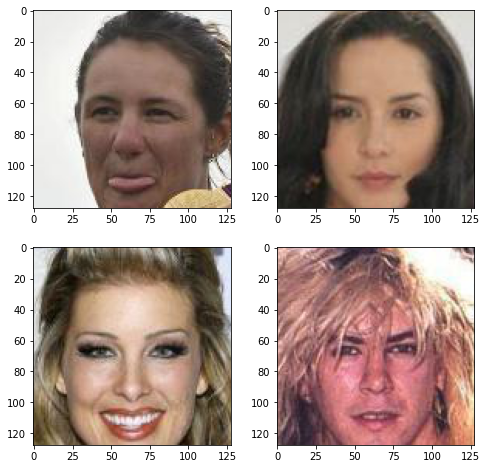

In [33]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images = next(dataiter)
image_transform = transforms.ToPILImage()

f, axs = plt.subplots(2,2, figsize=(8,8))
axs[0,0].imshow(image_transform(images[0]))
axs[0,1].imshow(image_transform(images[1]))
axs[1,0].imshow(image_transform(images[2]))
axs[1,1].imshow(image_transform(images[3]))
plt.show()


# Model architecture for Encoder

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Encoder(nn.Module):
    def __init__(self, in_channels, conv_channels, conv_filters, 
                 conv_strides, dense_units_in, dense_units_out, dropout):
        super(Encoder, self).__init__()


        self.conv0 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=conv_channels[0], 
                               kernel_size=conv_filters[0], stride=conv_strides[0], 
                               padding=1)
        self.norm0 = nn.BatchNorm2d(conv_channels[0])
        self.dropout0 = nn.Dropout2d(dropout)

        for i in range(1, len(conv_channels)):
            exec(f"""self.conv{i} = nn.Conv2d(in_channels=conv_channels[i-1], 
                        out_channels=conv_channels[i], 
                        kernel_size=conv_filters[i], stride=conv_strides[i], 
                        padding=1)"""
            )
            exec(f"self.norm{i} = nn.BatchNorm2d(conv_channels[{i}])")
            exec(f"self.dropout{i} = nn.Dropout2d(dropout)")
        
        self.flatten1 = nn.Flatten()
        self.mu = nn.Linear(in_features=dense_units_in[0], out_features=dense_units_out[0], bias=True)    
        self.log_var = nn.Linear(in_features=dense_units_in[0], out_features=dense_units_out[0], bias=True)  


    def forward(self, x):
        x = self.dropout0(F.leaky_relu(self.norm0(self.conv0(x))))
        x = self.dropout1(F.leaky_relu(self.norm1(self.conv1(x))))
        x = self.dropout2(F.leaky_relu(self.norm2(self.conv2(x))))
        x = self.dropout3(F.leaky_relu(self.norm3(self.conv3(x))))
        x = self.flatten1(x) 
        x_mu = self.mu(x)
        x_log_var = self.log_var(x)
        return [x_mu, x_log_var]

conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [2, 2, 2, 2]
dense_units_out = [200]
dense_units_in = [4096]
my_encoder = Encoder(in_channels=3, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units_in=dense_units_in, dense_units_out=dense_units_out, 
             dropout=0.25)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
my_encoder = my_encoder.to(device)
summary(my_encoder, input_size=(3, image_size, image_size))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         Dropout2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
           Conv2d-10             [-1, 64, 8, 8]          36,928
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        Dropout2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14            

# Model Architecture for Decoder

In [8]:
class Decoder(nn.Module):

  def __init__(self, in_dim, tconv_channels, tconv_filters, tconv_strides, 
               dense_units, output_padding, dropout):
    super().__init__()
    self.dense1 = nn.Linear(in_dim, dense_units[0])
    
    self.tconv0 = nn.ConvTranspose2d(in_channels=64, 
                                     out_channels=tconv_channels[0], 
                                     kernel_size=tconv_filters[0], 
                                     stride=tconv_strides[0], 
                                     padding=1, output_padding=output_padding[0])
    self.norm0 = nn.BatchNorm2d(tconv_channels[0])
    self.dropout0 = nn.Dropout2d(dropout)

    self.tconv1 = nn.ConvTranspose2d(in_channels=tconv_channels[0], 
                                     out_channels=tconv_channels[1], 
                                     kernel_size=tconv_filters[1], 
                                     stride=tconv_strides[1], 
                                     padding=1, output_padding=output_padding[1])
    self.norm1 = nn.BatchNorm2d(tconv_channels[1])
    self.dropout1 = nn.Dropout2d(dropout)


    self.tconv2 = nn.ConvTranspose2d(in_channels=tconv_channels[1], 
                                     out_channels=tconv_channels[2], 
                                     kernel_size=tconv_filters[2], 
                                     stride=tconv_strides[2], 
                                     padding=1, output_padding=output_padding[2])
    self.norm2 = nn.BatchNorm2d(tconv_channels[2])
    self.dropout2 = nn.Dropout2d(dropout)   


    self.tconv3 = nn.ConvTranspose2d(in_channels=tconv_channels[2], 
                                     out_channels=tconv_channels[3], 
                                     kernel_size=tconv_filters[3], 
                                     stride=tconv_strides[3], 
                                     padding=1, output_padding=output_padding[3])     

    
  def forward(self, x):
    x = self.dense1(x)
    x = torch.reshape(x, [-1, 64, 8, 8])
    x = self.dropout0(F.leaky_relu(self.norm0(self.tconv0(x))))
    x = self.dropout1(F.leaky_relu(self.norm1(self.tconv1(x))))
    x = self.dropout2(F.leaky_relu(self.norm2(self.tconv2(x))))
    x = torch.sigmoid(self.tconv3(x))
    return x


tconv_channels = [64, 64, 32, 3]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [2,2,2,2]
dense_units = [4096]
output_padding=[1,1,1,1]
my_decoder = Decoder(in_dim=200, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding, dropout=0.25)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_decoder = my_decoder.to(device)
summary(my_decoder, input_size=(200,))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         823,296
   ConvTranspose2d-2           [-1, 64, 16, 16]          36,928
       BatchNorm2d-3           [-1, 64, 16, 16]             128
         Dropout2d-4           [-1, 64, 16, 16]               0
   ConvTranspose2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         Dropout2d-7           [-1, 64, 32, 32]               0
   ConvTranspose2d-8           [-1, 32, 64, 64]          18,464
       BatchNorm2d-9           [-1, 32, 64, 64]              64
        Dropout2d-10           [-1, 32, 64, 64]               0
  ConvTranspose2d-11          [-1, 3, 128, 128]             867
Total params: 916,803
Trainable params: 916,803
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
For

# Model Architecture for Variational AutoEncoder

In [46]:
from torch.distributions.multivariate_normal import MultivariateNormal

class VarAutoEncoder(nn.Module):

    def __init__(self, in_channels, dec_in_dim, conv_channels, conv_filters, conv_strides, 
                       enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, tconv_strides,
                       dec_dense_units, output_padding, dropout):
      super().__init__()
      self.encoder = Encoder(in_channels=in_channels, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units_in=enc_dense_in, dense_units_out=enc_dense_out, dropout=dropout)
      self.decoder = Decoder(in_dim=dec_in_dim, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding, dropout=dropout)
      self.normal_dist = MultivariateNormal(torch.zeros(enc_dense_out[0]), torch.eye(enc_dense_out[0]))   
       

    def forward(self, x, decode=True):
      mu, log_var = self.encoder(x)
      epsilon = self.normal_dist.sample((x.shape[0],))
      epsilon = epsilon.to(device)
      z = mu + (torch.sqrt(torch.exp(log_var)) / 2) * epsilon # z = mu + sqrt(exp(log_var)) / 2 * epsilon where epsilon ~ N(0,1)
      if not decode:
        return [z, mu, log_var]

      return [self.decoder(z), mu, log_var]


tconv_channels = [64, 64, 32, 3]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [2, 2, 2, 2]
dec_dense_units = [4096]
output_padding=[1,1,1,1]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [2, 2, 2, 2]
enc_dense_out = [200]
enc_dense_in = [4096]
dropout = 0.25

my_auto_encoder = VarAutoEncoder(3, 200, conv_channels, conv_filters, conv_strides, 
                              enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_auto_encoder = my_auto_encoder.to(device)
summary(my_auto_encoder, input_size=(3, image_size, image_size))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         Dropout2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
           Conv2d-10             [-1, 64, 8, 8]          36,928
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        Dropout2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14              

# Custom Loss Function

In [10]:
class VAELoss(nn.Module):
    def __init__(self, weight=1.0, use_KL=True):
        super(VAELoss, self).__init__()
        self.rec_weight = weight
        self.reconstruction_loss = nn.MSELoss(reduction='none')
        self.kl_weight = 1.0 if use_KL else 0

    def forward(self, output, target, mu, log_var):
        vae_loss_reconstruction = torch.sum(self.reconstruction_loss(output, target))
        vae_loss_kl = -0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var), dim=1)
        vae_loss = vae_loss_reconstruction * self.rec_weight + vae_loss_kl * self.kl_weight
        return torch.sum(vae_loss)

In [11]:
import math
print(device)
# Test everything manually

# Manually do the sampling
x = images[0:5].to(device)
print(x.shape)
#x = x.unsqueeze(0)
mu, log_var = my_encoder(x)
epsilon = MultivariateNormal(torch.zeros(200), torch.eye(200)).sample((x.shape[0],)) 
epsilon = epsilon.to(device)
z = mu + (torch.sqrt(torch.exp(log_var)) / 2) * epsilon
y = my_decoder(z)
print(f'input shape: {x.shape}')
print(f'encoded mu shape: {mu.shape}')
print(f'encoded log_var shape: {log_var.shape}')
print(f'sample shape: {z.shape}')
print(f'decoded output shape: {y.shape}')


# Sample from within autoencoder
y, mu, log_var = my_auto_encoder(x, decode=True)
z, _, _ = my_auto_encoder(x, decode=False)
print()
print(f'input shape: {x.shape}')
print(f'encoded mu shape: {mu.shape}')
print(f'encoded log_var shape: {log_var.shape}')
print(f'sample shape: {z.shape}')
print(f'decoded output shape: {y.shape}')

# Test loss function
criterion = VAELoss(weight=0.5, use_KL=True)
loss = criterion(y, x, mu, log_var)
print()
#print(f'mu: {mu}')
#print(f'log_var: {log_var}')
print(f'loss (with KL): {loss.item()}')
criterion = VAELoss(weight=0.5, use_KL=False)
loss = criterion(y, x, mu, log_var)
print(f'loss (without KL): {loss.item()}')

cuda
torch.Size([5, 3, 128, 128])
input shape: torch.Size([5, 3, 128, 128])
encoded mu shape: torch.Size([5, 200])
encoded log_var shape: torch.Size([5, 200])
sample shape: torch.Size([5, 200])
decoded output shape: torch.Size([5, 3, 128, 128])

input shape: torch.Size([5, 3, 128, 128])
encoded mu shape: torch.Size([5, 200])
encoded log_var shape: torch.Size([5, 200])
sample shape: torch.Size([5, 200])
decoded output shape: torch.Size([5, 3, 128, 128])

loss (with KL): 85851.578125
loss (without KL): 85695.3125


# Training

In [12]:
def calculate_test_loss(autoencoder, test_loader, criterion, device):
    autoencoder.eval()
    with torch.no_grad(): 
 
        reconstructed_images = []
        original_images = []
        test_loss_total = 0
  
        for images in test_loader:
            images = images.to(device)
            y, mu, log_var = autoencoder(images)
            loss = criterion(y, images, mu, log_var)
            test_loss_total += loss.item()

    return test_loss_total



In [47]:
from tqdm.notebook import tqdm
import torch.optim as optim

torch.manual_seed(555)
epochs = 10
criterion = VAELoss(weight=0.009, use_KL=True)
optimizer = optim.Adam(my_auto_encoder.parameters(), lr=0.0001)

train_loss_epoch = []
test_loss_epoch = []
for epoch in tqdm(range(1, epochs+1)):
  my_auto_encoder.train()
  loss_train_total = 0
  train_loss_batch = []

  progress_bar = tqdm(trainloader, desc=f'epoch: {epoch}', leave=False, disable=False)
  for batch in progress_bar:

    my_auto_encoder.zero_grad()
    images = batch.to(device)    
    my_auto_encoder.to(device)

    reconstructed_images, mu, log_var = my_auto_encoder(images)
    loss = criterion(reconstructed_images, images, mu, log_var)
    loss_train_total += loss.item()
    train_loss_batch.append(loss.item())

    loss.backward()
    optimizer.step()

    progress_bar.set_postfix(
        {
            'training_loss (per image in current batch)': '{:.3f}'.format(loss.item()/len(batch))
        }
    )

  
  tqdm.write(f'\nEpoch: {epoch}')

  loss_train_avg = loss_train_total / len(trainloader)
  train_loss_epoch.append(loss_train_avg)
  tqdm.write(f'Avg Training Loss: {loss_train_avg}')

  test_loss_avg = calculate_test_loss(my_auto_encoder, testloader, criterion, device) / len(testloader)
  test_loss_epoch.append(test_loss_avg)
  tqdm.write(f'Avg Test Loss: {test_loss_avg}')



  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 1
Avg Training Loss: 50697.2787495739
Avg Test Loss: 28707.783735226363


epoch: 2:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 2
Avg Training Loss: 32487.39025619795
Avg Test Loss: 25484.190323267227


epoch: 3:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 3
Avg Training Loss: 29264.26778023198
Avg Test Loss: 22686.355850610977


epoch: 4:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 4
Avg Training Loss: 27729.765190844268
Avg Test Loss: 22128.258419721555


epoch: 5:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 5
Avg Training Loss: 26794.67175561677
Avg Test Loss: 22031.27398838141


epoch: 6:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 6
Avg Training Loss: 26127.70940173647
Avg Test Loss: 21296.500532101363


epoch: 7:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 7
Avg Training Loss: 25625.343701728485
Avg Test Loss: 22024.501978165063


epoch: 8:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 8
Avg Training Loss: 25225.266134202106
Avg Test Loss: 20601.257205278445


epoch: 9:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 9
Avg Training Loss: 24907.486959205482
Avg Test Loss: 20821.365152994793


epoch: 10:   0%|          | 0/2544 [00:00<?, ?it/s]


Epoch: 10
Avg Training Loss: 24618.078708192836
Avg Test Loss: 20646.955240885418


# Loss Curves on Train/Test




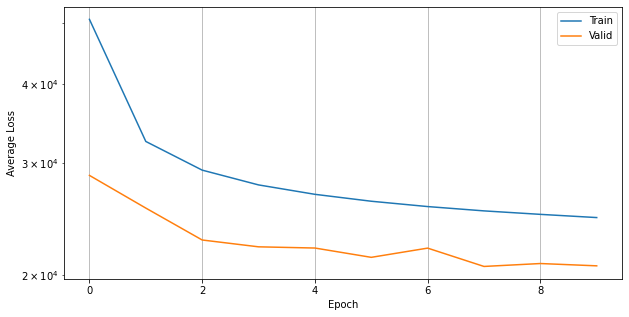

In [48]:
plt.figure(figsize=(10,5))
plt.semilogy(train_loss_epoch, label='Train')
plt.semilogy(test_loss_epoch, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.show()

# Save/Load the model

In [49]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(my_auto_encoder.state_dict(), '/content/drive/My Drive/Models/CELEBA_VAE_epoch5c.model')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
tconv_channels = [64, 64, 32, 3]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [2, 2, 2, 2]
dec_dense_units = [4096]
output_padding=[1,1,1,1]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [2, 2, 2, 2]
enc_dense_out = [200]
enc_dense_in = [4096]
dropout=0.2

my_auto_encoder = VarAutoEncoder(3, 200, conv_channels, conv_filters, conv_strides, 
                              enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding, dropout=dropout)

my_auto_encoder.load_state_dict(torch.load('/content/drive/My Drive/Models/CELEBA_VAE_epoch5c.model', map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_auto_encoder = my_auto_encoder.to(device)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Autoencode test images

In [50]:
from tqdm.notebook import tqdm

def autoencode_images(autoencoder, testloader, device, nbatches=50):
    autoencoder.eval()
    with torch.no_grad(): 
 
        encoded_images = []
        reconstructed_images = []
        original_images = []
        i = 0
        for images in tqdm(testloader): 
            i += 1
            if i > nbatches: break
            images = images.to(device)
            outputs_encoded, _, _ = autoencoder(images, decode=False)
            outputs_decoded, _, _ = autoencoder(images, decode=True)

            reconstructed_images.append(outputs_decoded.cpu())
            original_images.append(images.cpu())
            encoded_images.append(outputs_encoded.cpu())

    return original_images, encoded_images, reconstructed_images


original_images, encoded_images, reconstructed_images = (
    autoencode_images(my_auto_encoder, testloader, device)
)
original_images = torch.cat(original_images, 0)
encoded_images = torch.cat(encoded_images, 0)
reconstructed_images = torch.cat(reconstructed_images, 0)

  0%|          | 0/312 [00:00<?, ?it/s]

# Visualize Reconstructed images from Test set


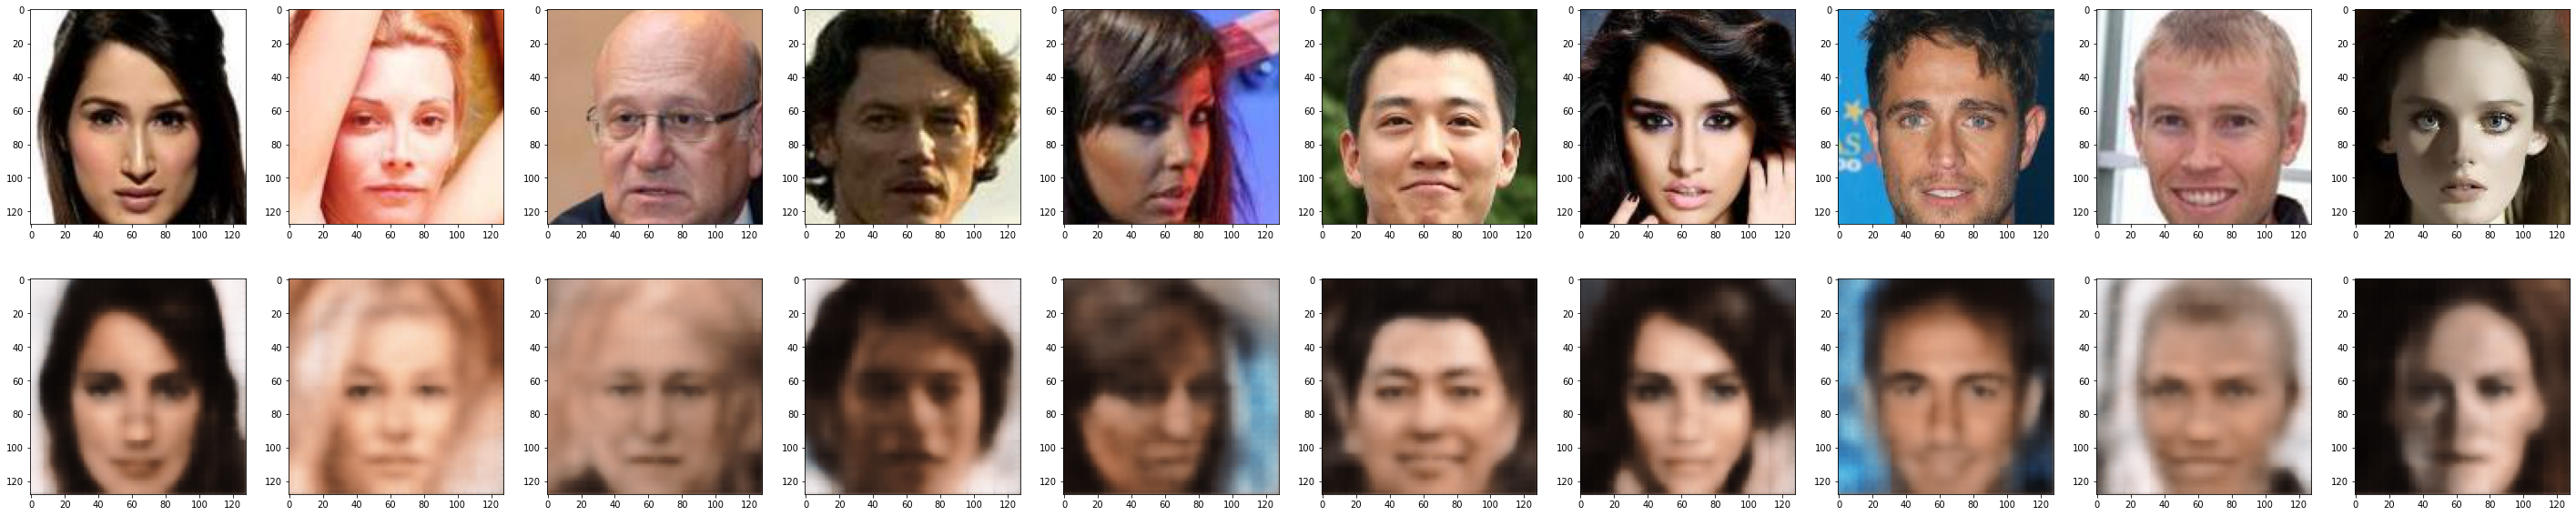

In [51]:
fig, axs = plt.subplots(2, 10, figsize=(50,10))
transform = transforms.ToPILImage()
for i in range(10):
    idx = np.random.choice(original_images.shape[0], size=1)[0]
    img = torch.squeeze(original_images[idx], 0)
    axs[0, i].imshow(transform(img))
  
    img = torch.squeeze(reconstructed_images[idx], 0)
    axs[1, i].imshow(transform(img))


# Generate novel images

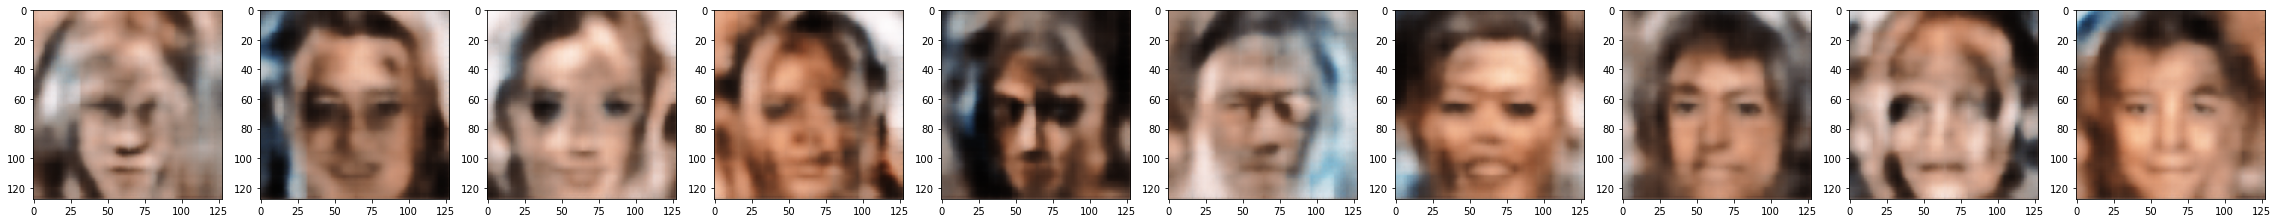

In [52]:
from torch.distributions.multivariate_normal import MultivariateNormal

def get_novel_face(autoencoder, hidden_dim, device, n=12):
    m = MultivariateNormal(torch.zeros(hidden_dim), torch.eye(hidden_dim))
    a = m.sample((n,))
    a = a.to(device)
    novel_faces = my_auto_encoder.decoder(a)
    return novel_faces 

n = 10
novel_faces = get_novel_face(my_auto_encoder, 200, device, n=n)
fig, axs = plt.subplots(1,n, figsize=(40,15))
transform = transforms.ToPILImage()
for i in range(novel_faces.shape[0]):
    img = novel_faces[i]
    axs[i].imshow(transform(img))


# Check encoded distributions univariately

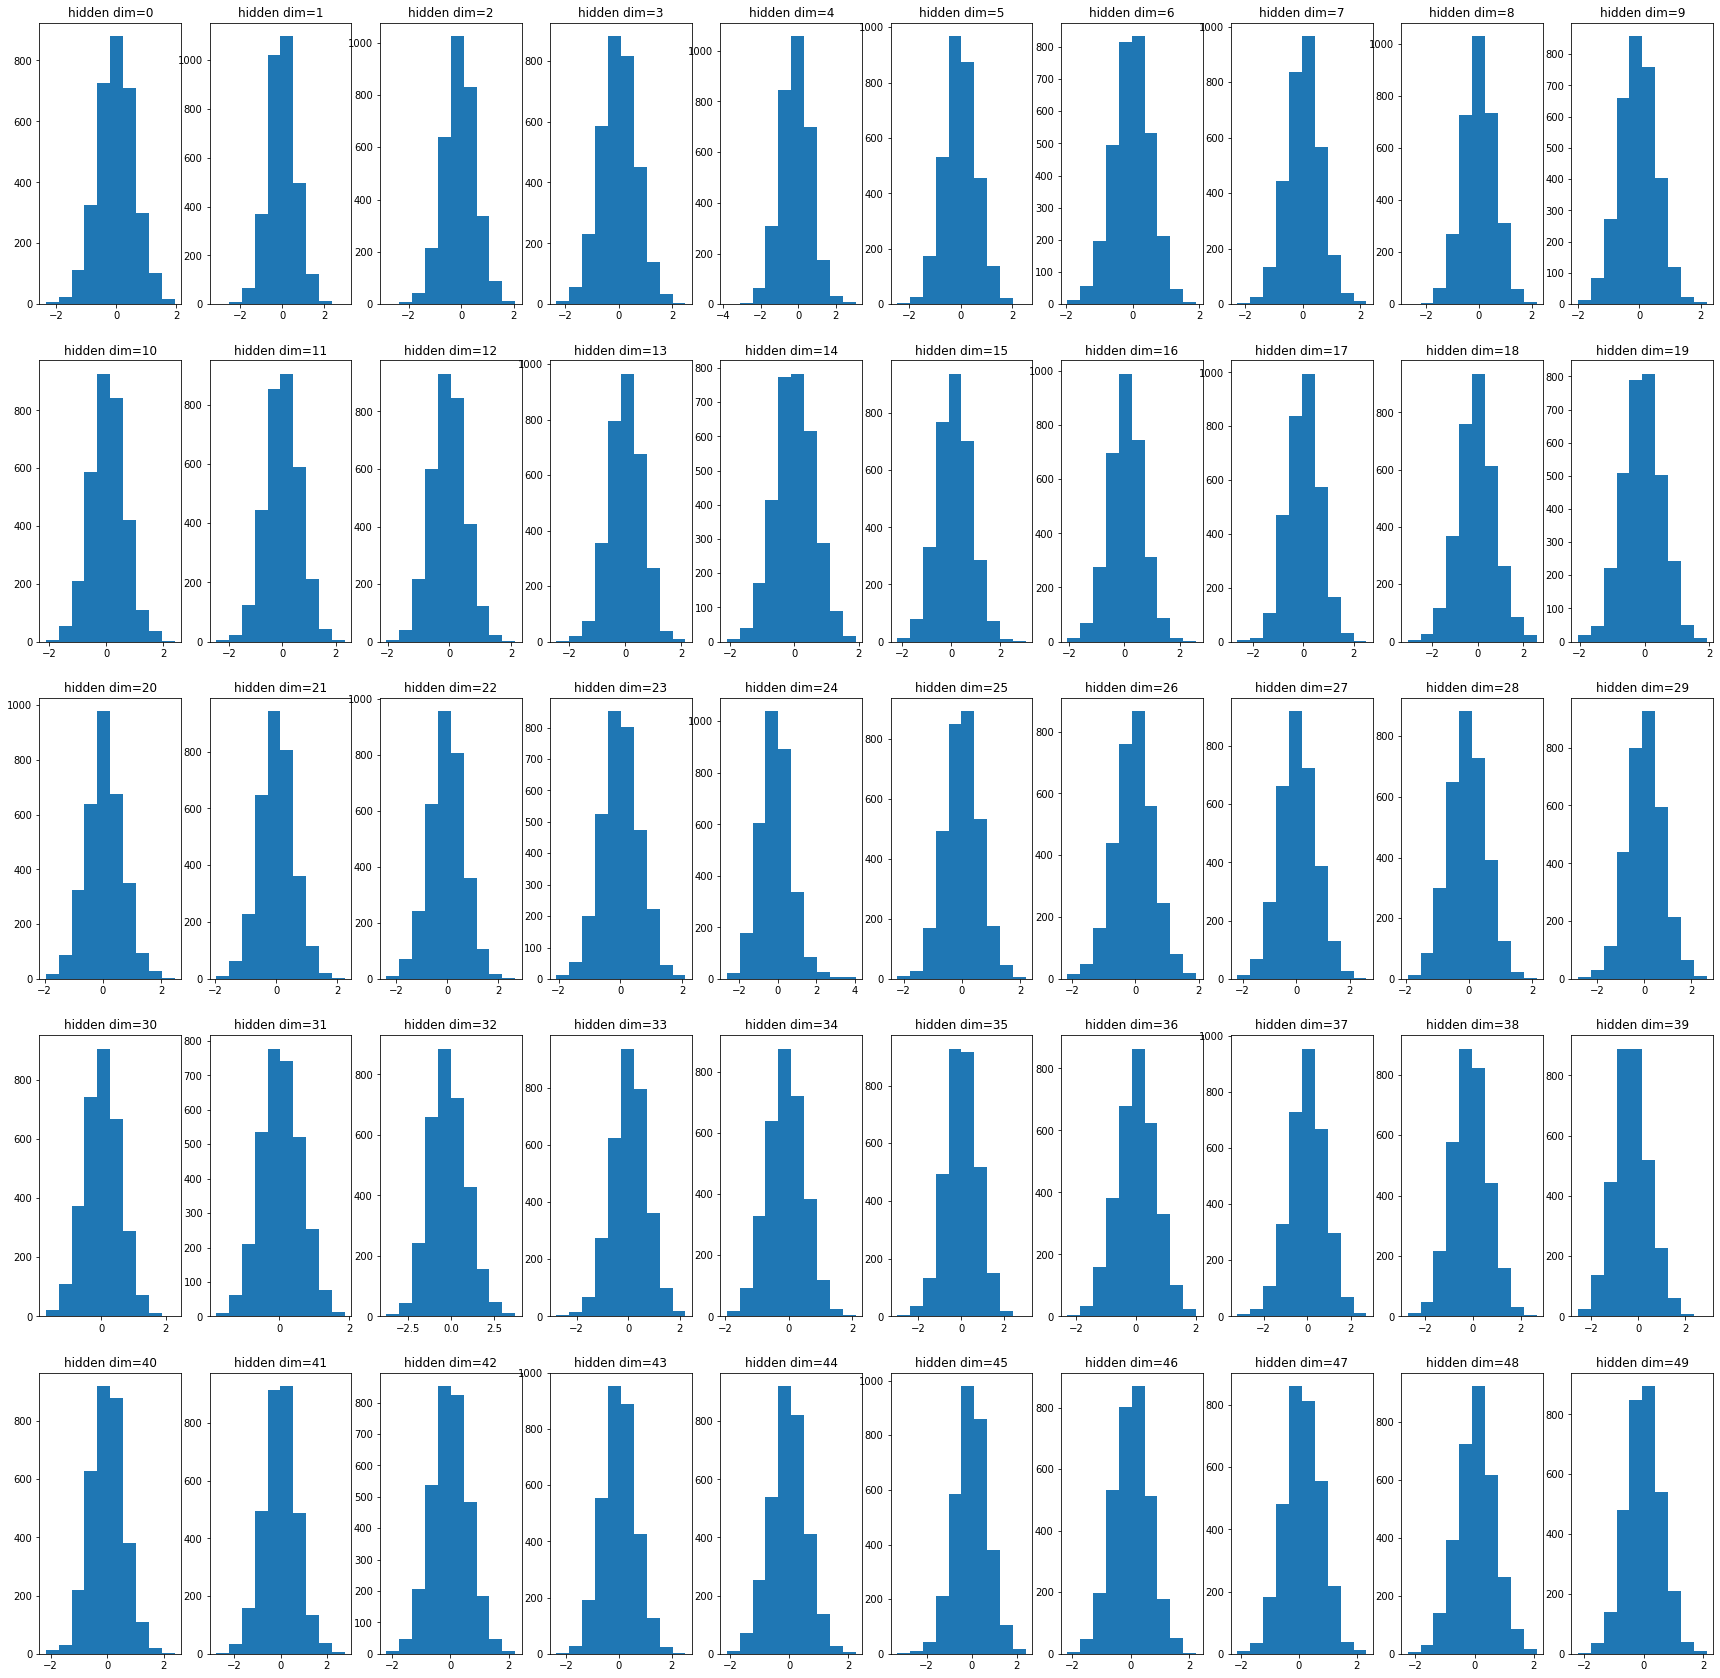

In [53]:
check_first_n_dims = 50
nrows = int(check_first_n_dims / 10)
ncols = int(check_first_n_dims / nrows)
fig, ax = plt.subplots(nrows, ncols, figsize=(30,30))

d = 0
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].hist(encoded_images[:, d].numpy())
    ax[i,j].set_title(f'hidden dim={d}')
    d += 1

# Vector arithmetic (add attribute to image)

In [26]:
from tqdm.notebook import tqdm

def encode_images_only(autoencoder, loader, device, nbatches=50):
    autoencoder.eval()
    with torch.no_grad(): 
        encoded_images = []
        for images in tqdm(loader): 
            images = images.to(device)
            outputs_encoded, _, _ = autoencoder(images, decode=False)
            encoded_images.append(outputs_encoded.cpu())

    return torch.cat(encoded_images, 0)



image_size = 128
transform = transforms.Compose([
    #transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])

# Create encoded vector for attribute (average of all testset encoded vectors with attribute)
labels_df = pd.read_csv('./list_attr_celeba.csv')
attribute = 'Smiling'
mask_attribute = (labels_df[attribute] == 1) & (eval_df['partition'] == 2)
mask_not_attribute = (labels_df[attribute] == -1) & (eval_df['partition'] == 2)


attribute_files = list(labels_df[mask_attribute]['image_id'])
not_attribute_files = list(labels_df[mask_not_attribute]['image_id'])

attribute_dataset = CelebADataset(root_dir=img_folder, image_names=attribute_files, 
                                  transform=transform)
attributeloader = DataLoader(attribute_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=2)
not_attribute_dataset = CelebADataset(root_dir=img_folder, image_names=not_attribute_files, 
                                      transform=transform)
not_attributeloader = DataLoader(not_attribute_dataset, batch_size=batch_size, shuffle=False, 
                                 num_workers=2)

encoded_images_attribute = encode_images_only(my_auto_encoder, attributeloader, device)
attribute_vector = torch.mean(encoded_images_attribute, 0)
print(attribute_vector.shape)

encoded_images_not_attribute = encode_images_only(my_auto_encoder, not_attributeloader, device)
not_attribute_vector = torch.mean(encoded_images_not_attribute, 0)
print(not_attribute_vector.shape)

delta_vector = attribute_vector - not_attribute_vector

  0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([200])


  0%|          | 0/156 [00:00<?, ?it/s]

torch.Size([200])


cuda


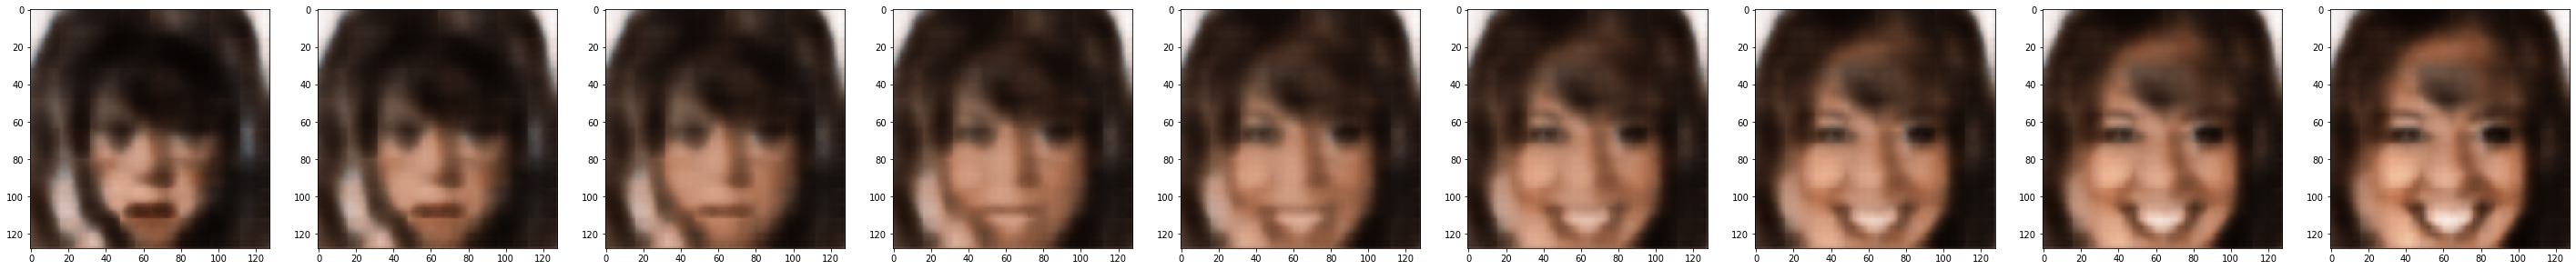

In [44]:
delta_vector = attribute_vector - not_attribute_vector
delta_vector = delta_vector.to(device)

print(device)
# Get a test example that does not have the attribute and encode it
indx=50
x = test_dataset[indx].unsqueeze(0)
x = x.to(device)
img_encoded, _, _ = my_auto_encoder(x, decode=False) 

# Create versions of image with more of the chosen attribute
image_attribute_spectrum = []
for i in np.linspace(-4,4,9):
  tmp = img_encoded + i * delta_vector
  image_attribute_spectrum.append(my_auto_encoder.decoder(tmp))

image_attribute_spectrum = torch.cat(image_attribute_spectrum,0)

fig, axs = plt.subplots(1, image_attribute_spectrum.shape[0], figsize=(50,50))
transform = transforms.ToPILImage()
for i in range(image_attribute_spectrum.shape[0]):
    img = image_attribute_spectrum[i]
    axs[i].imshow(transform(img))


# Morph Faces

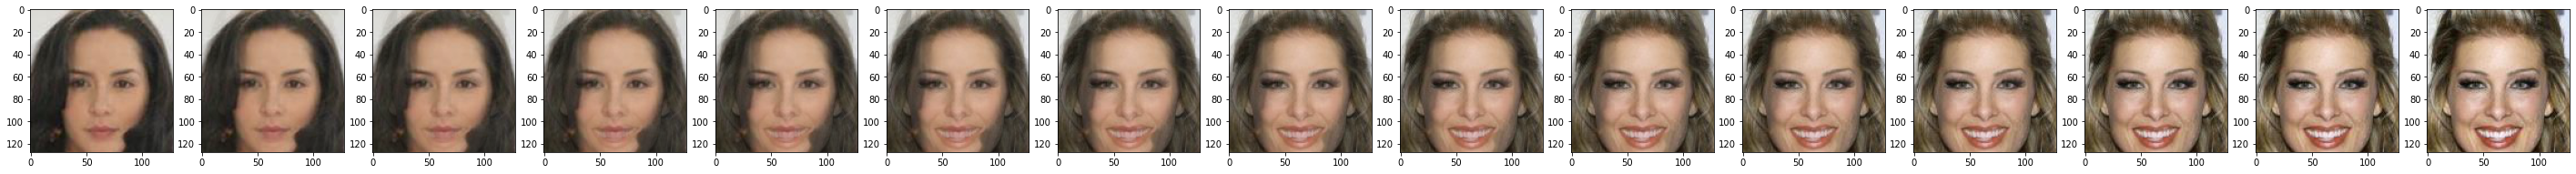

In [36]:
start_image = images[1].unsqueeze(0)
end_image = images[2].unsqueeze(0)
image_morph = []

for alpha in np.linspace(start=1, stop=0, num=15):
  image_morph.append(start_image * alpha + (1-alpha) * end_image)
image_morph = torch.cat(image_morph, 0) 

fig, axs = plt.subplots(1, image_morph.shape[0], figsize=(50,50))
transform = transforms.ToPILImage()
for i in range(image_morph.shape[0]):
    img = image_morph[i]
    axs[i].imshow(transform(img))  